In [1]:
import os
os.chdir('../src')

In [2]:
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import RandomSampler, SequentialSampler

In [3]:
from data_builder.dataset import cassavaTrain
#from data_builder.transforms import get_train_transform
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from config import _C as cfg

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def get_train_transform(cfg):

    return A.Compose([
        #A.OneOf([
        #  A.OpticalDistortion(p=cfg.DATASET.P_OPTICAL_DIST),
        #  A.GridDistortion(p=cfg.DATASET.P_GRID_DIST),
        #  A.IAAPiecewiseAffine(p=cfg.DATASET.P_PIECEWISE_AFFINE),
        #], p=0.3),
        #A.OneOf([
        #  A.HueSaturationValue(10,15,10, p=cfg.DATASET.P_HUE_SATURATION),
        #  A.CLAHE(clip_limit=2, p=cfg.DATASET.P_CLAHE),
        #  #A.RandomBrightnessContrast(p=cfg.DATASET.P_RANDOM_BRIGHTNESS),            
        #], p=0.3),
        A.RandomResizedCrop(cfg.DATASET.IMG_HEIGHT, cfg.DATASET.IMG_HEIGHT, p=cfg.DATASET.P_RANDOMRESCROP),
        #A.CenterCrop(cfg.DATASET.IMG_HEIGHT, cfg.DATASET.IMG_HEIGHT, p=cfg.DATASET.P_CENTERCROP),
        #A.Cutout(num_holes=cfg.DATASET.NUM_HOLES, p=cfg.DATASET.P_CUTOUT),
        A.HorizontalFlip(cfg.DATASET.P_HORIZONATL_FLIP),
        A.VerticalFlip(cfg.DATASET.P_VERTICAL_FLIP),
        A.RandomRotate90(cfg.DATASET.P_RANDOM_ROTATE),
        A.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=cfg.DATASET.P_SHIFT_SCALE, 
            border_mode=cv2.BORDER_REFLECT
        ),
        A.Resize(height=cfg.DATASET.IMG_HEIGHT, width=cfg.DATASET.IMG_WIDTH),
        #A.Normalize(
        #    mean=[0.42984136, 0.49624753, 0.3129598], 
        #    std=[0.23297946,0.2358761,0.22365381],
        #    always_apply=True
        #),
        ToTensorV2()
    ])

In [7]:
train_trnsf = get_train_transform(cfg)

In [8]:
df_train = pd.read_csv(
    '/home/giorgio/Scrivania/Kaggle/cassava_leaf/data/train_folds.csv'
)

with open('/home/giorgio/Scrivania/Kaggle/cassava_leaf/data/label_num_to_disease_map.json', 'rb') as f:
    transcod = json.load(f)

In [9]:
data = cassavaTrain(
    df = df_train,
    cfg = cfg,
    transforms = train_trnsf
)

dl = DataLoader(
    dataset=data,
    sampler=RandomSampler(data),
    drop_last=True,
    batch_size=cfg.TRAIN_LOADER.BATCH_SIZE,
    num_workers=cfg.TRAIN_LOADER.NUM_WORKERS
)

In [10]:
imgs, labels, ids = next(iter(dl))

In [11]:
idx_sample = np.random.choice(list(range(len(imgs))))
img = imgs[idx_sample].permute(1,2,0).detach().cpu().numpy()
label = labels[idx_sample].detach().cpu().numpy()
id_img = ids[idx_sample]

In [12]:
label = transcod[str(label.item())]

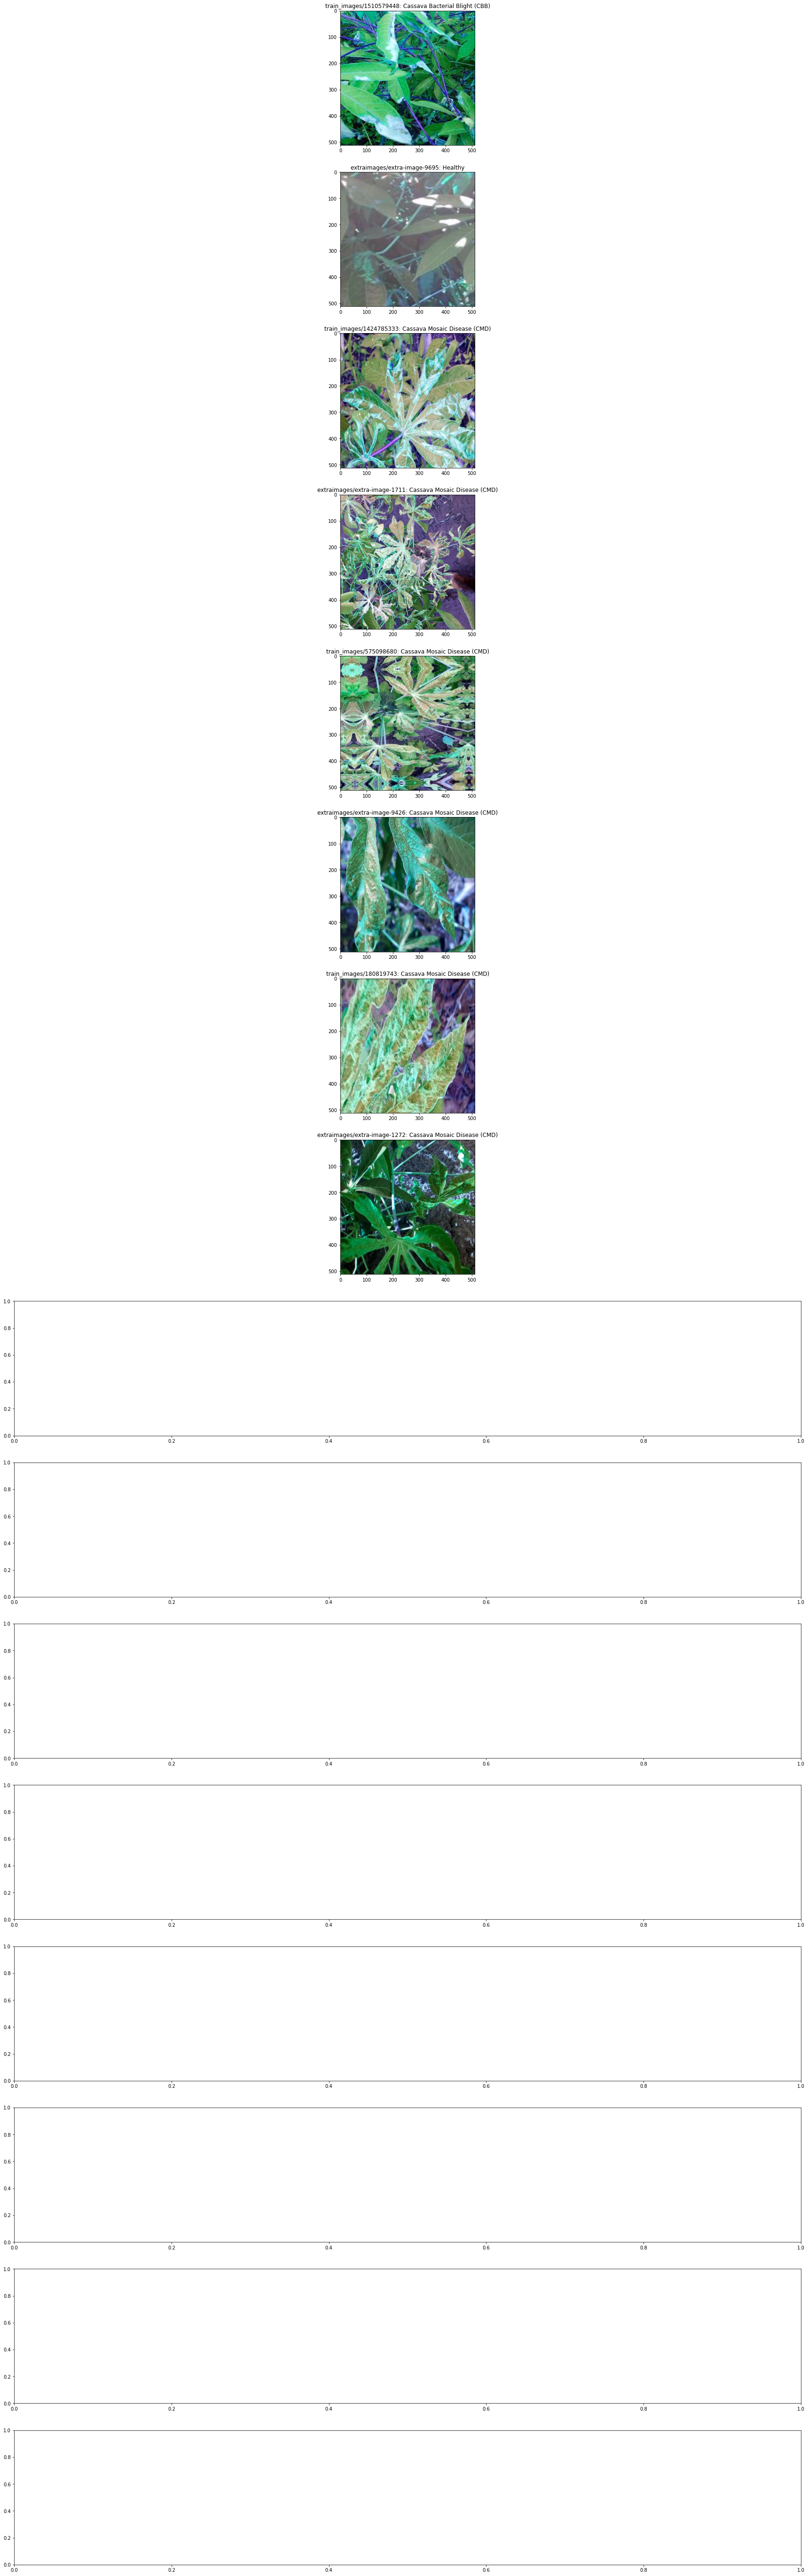

In [13]:
fig, axes = plt.subplots(16, 1, figsize=(30,100))
for cnt in range(imgs.shape[0]):
    img = imgs[cnt].permute(1,2,0).detach().cpu().numpy()
    label = labels[cnt].detach().cpu().numpy()
    id_img = ids[cnt]
    label = transcod[str(label.item())]

    axes[cnt].imshow(img)
    axes[cnt].set_title(f'{id_img}: {label}')